In [1]:
#LIBRERIAS
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras import layers, models, regularizers
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
import seaborn as sns
import collections

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#retina_df = pd.read_csv("../Datos/Retina_DF_BAL.csv")
retina_df = pd.read_csv("../content/drive/MyDrive/Img_Preprocessing_v1_BINARIO/Retina_DF_BAL_BINARIO.csv")

retina_df.head(6)

,image,level,id_Paciente,path,existe,tipo,eye,level_Binario
0,40319_right,4,40319,..\Datos\Train\40319_right.jpeg,True,CON RD,1,1
1,9419_left,4,9419,..\Datos\Train\9419_left.jpeg,True,CON RD,0,1
2,13742_right,0,13742,..\Datos\Train\13742_right.jpeg,True,SIN RD,1,0
3,18931_left,0,18931,..\Datos\Train\18931_left.jpeg,True,SIN RD,0,0
4,2205_left,2,2205,..\Datos\Train\2205_left.jpeg,True,CON RD,0,1
5,40131_left,0,40131,..\Datos\Train\40131_left.jpeg,True,SIN RD,0,0


In [4]:
retina_df.shape

(1800, 8)

In [5]:
direccion = "../content/drive/MyDrive/Img_Preprocessing_v1_BINARIO/"
lear_rate = 0.0005
batch_tam = 64
dimensiones = 224
num_clases = 1

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    direccion,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(dimensiones, dimensiones),
    batch_size=batch_tam)

val_ds = tf.keras.utils.image_dataset_from_directory(
    direccion,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(dimensiones, dimensiones),
    batch_size=batch_tam)

Found 1800 files belonging to 2 classes.
Using 1440 files for training.
Found 1800 files belonging to 2 classes.
Using 360 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['CON RD', 'SIN RD']


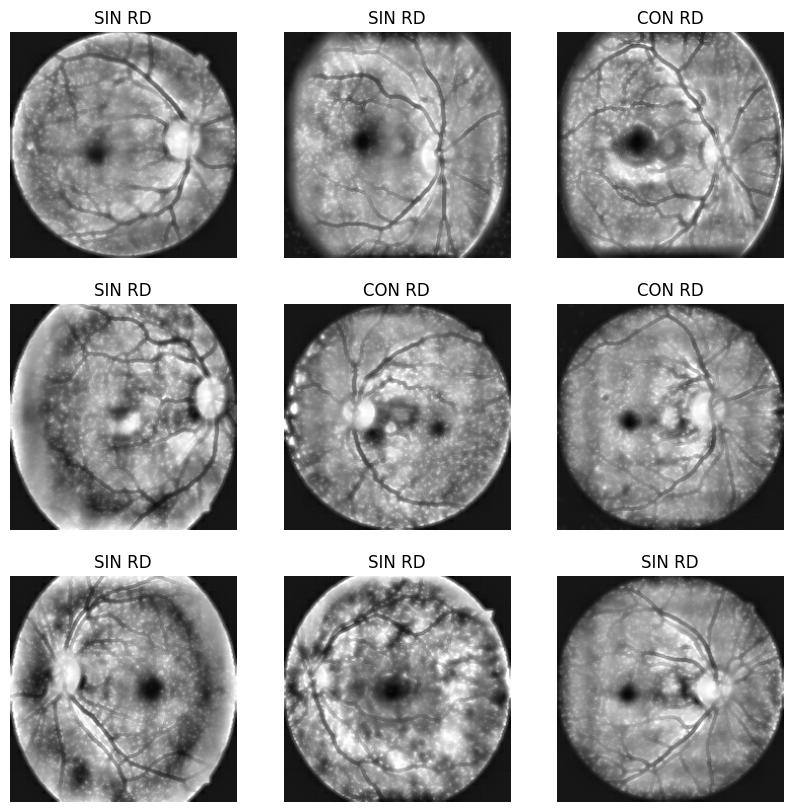

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
from tensorflow import keras

In [10]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.Rescaling(1./255)
])

normalization_layer = layers.Rescaling(1./255)

In [11]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

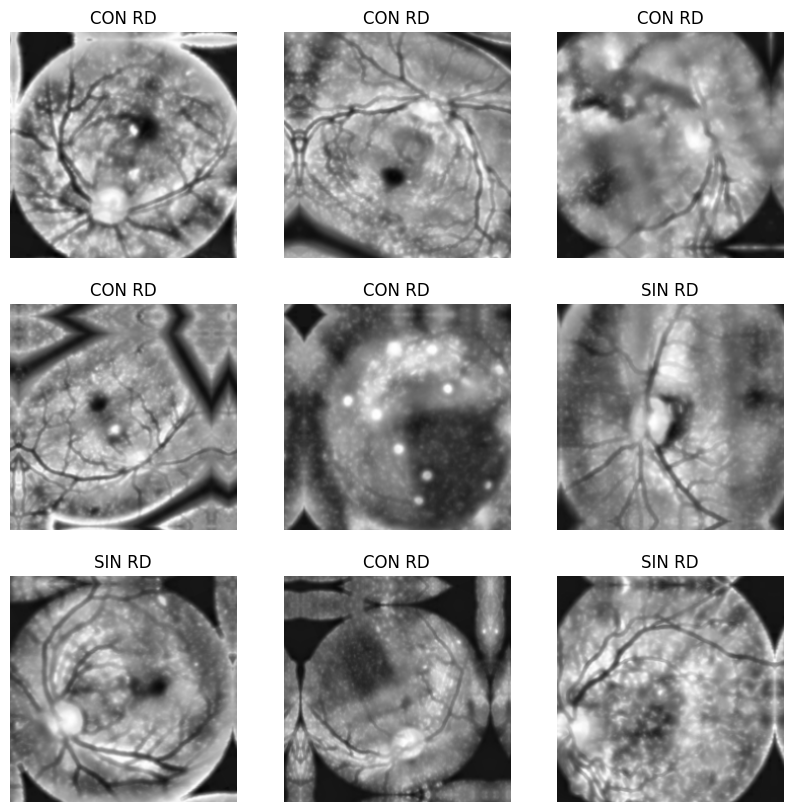

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i].numpy()*255).astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
#Assuming your segmentation ground truth has 0 and 1 values for each pixel
#and the shape of the target image is 256, 256, 1
#train_ds = train_ds.map(lambda img, mask: (img, mask)) #Change this line (from ipython-input-87-86b3ec2058c1)
#val_ds = val_ds.map(lambda img, mask: (img, mask)) #Change this line (from ipython-input-87-86b3ec2058c1)

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# model = tf.keras.Sequential([
#     tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(1, activation='sigmoid')  # Apply softmax point nr 1.
# ])

# model = tf.keras.Sequential([
#     tf.keras.layers.Rescaling(1./255, input_shape=(300, 300, 3)),
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(1, activation='sigmoid')  # Apply softmax point nr 1.
# ])

# base_model = tf.keras.applications.ResNet50(
#     weights='imagenet',  # Usar pesos preentrenados en ImageNet
#     include_top=False,   # Excluir la parte densa de la red
#     input_shape=(224, 224, 3)  # Tamaño de entrada de la imagen
# )

# base_model.trainable = True

# model = tf.keras.Sequential([
#     base_model,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(1, activation='sigmoid')  # Capa de salida
# ])

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Clasificación binaria
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Input
from tensorflow.keras.models import Model

In [18]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,705 (1.19 MB)

 Trainable params: 311,873 (1.19 MB)

 Non-trainable params: 832 (3.25 KB)

In [19]:
# unet = unet_model(input_shape=(256, 256, 3), num_classes=1)

# # Compilar el modelo
# unet.compile(optimizer=tf.keras.optimizers.Adam(),
#              loss='binary_crossentropy',  # Para segmentación binaria
#              metrics=['accuracy'])

# # Mostrar arquitectura
# unet.summary()

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [21]:
history = model.fit(train_ds,
                    epochs=50,
                    steps_per_epoch=len(train_ds),
                    validation_data=val_ds,
                    validation_steps=len(val_ds),
                    callbacks=[early_stopping])

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.5117 - loss: 0.9674 - val_accuracy: 0.5111 - val_loss: 0.9076
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.5466 - loss: 0.9391 - val_accuracy: 0.5111 - val_loss: 0.9109
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.5308 - loss: 0.9299 - val_accuracy: 0.5111 - val_loss: 0.9098
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.5719 - loss: 0.8852 - val_accuracy: 0.5111 - val_loss: 0.9081
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.5753 - loss: 0.8879 - val_accuracy: 0.5111 - val_loss: 0.9065
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.6217 - loss: 0.8522 - val_accuracy: 0.5028 - val_loss: 0.9026
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.6083 - loss: 0.8606 - val_accuracy: 0.4889 - val_loss: 0.9071
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.6272 - loss: 0.8493 - val_accuracy: 0.4

In [22]:
# history = unet.fit(
#     train_ds,
#     epochs=25,
#     validation_data=val_ds,
#     verbose=1
# )

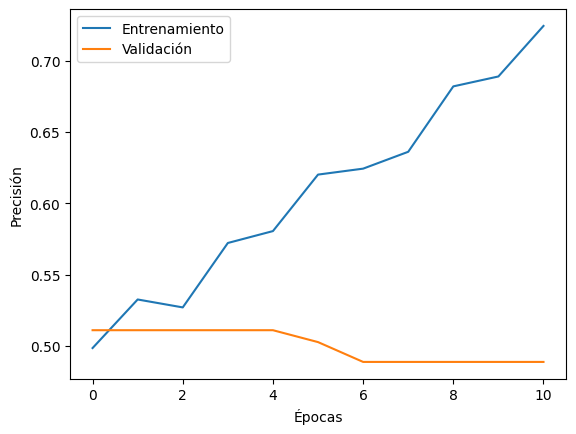

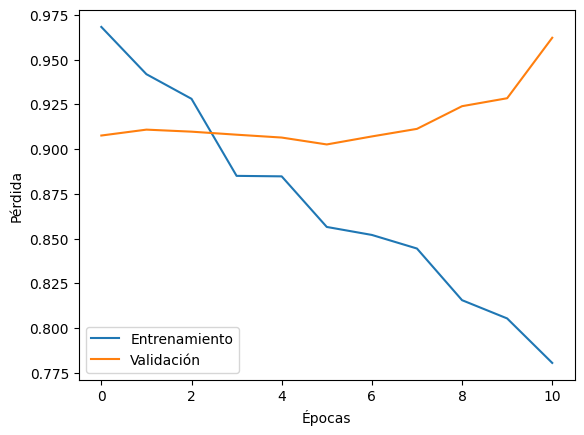

In [23]:
# Gráfica de precisión
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


In [27]:
loss, accuracy = model.evaluate(val_ds)
print('Loss:', loss)
print('Accuracy:', accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5092 - loss: 0.9024
Loss: 0.9026060104370117
Accuracy: 0.5027777552604675


In [24]:
y_pred = model.predict(val_ds)
y_ref = np.argmax(y_pred, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step


In [25]:
y_true = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())

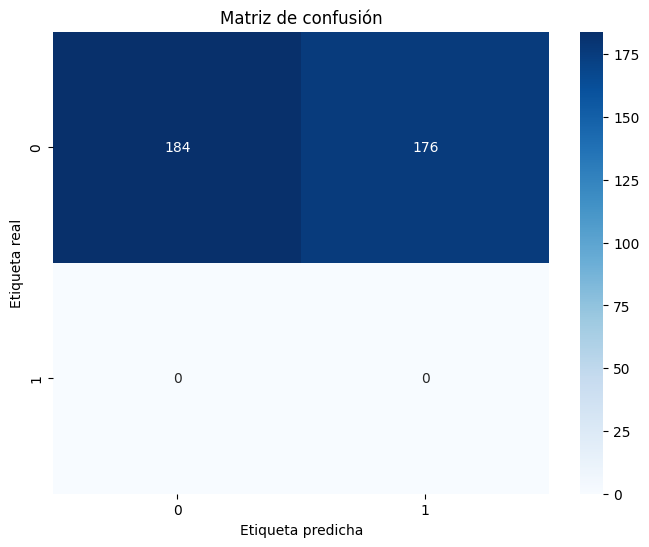

In [26]:
matriz_conf = confusion_matrix(y_ref,y_true)
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_conf, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de confusión")
plt.xlabel("Etiqueta predicha")
plt.ylabel("Etiqueta real")
plt.show()